**Костина Н. ggpolt**
-------------



In [69]:
install.packages("readxl")
install.packages("tidyxl")
install.packages("zoo")
install.packages("ggplot2")
install.packages("janitor")
install.packages("reshape2")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Подгружаем библиотеки

In [70]:
library("zoo")
library("readxl")
library("tidyxl")
library("magrittr")
library("dplyr")
library("tibble")
library("ggplot2")
library("data.table")
library("janitor")
library("reshape2")


На рисунке ниже можно видеть, что названия округов выделены жирным шрифтом, а субъекты, принадлежащие округу записаны ниже:


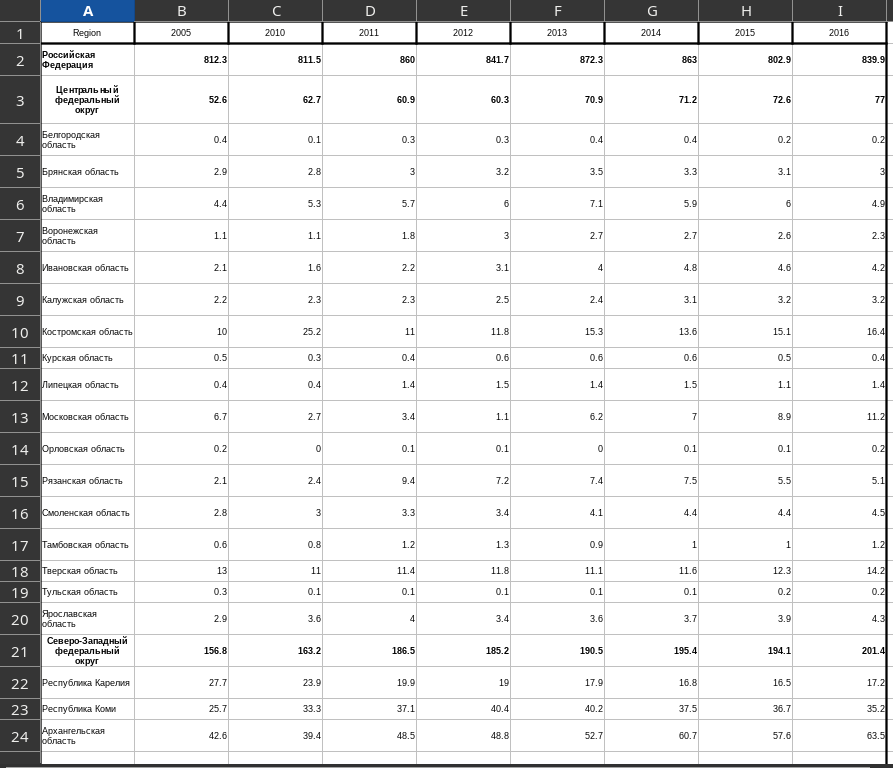


Функция, определяющая для каждой колонки формат текста, жирный текст или нет 

In [82]:
is_row_bold <- function(file_path) {
  cells <- xlsx_cells(file_path)
  formats <- xlsx_formats(file_path)
  formats$local$font$bold[cells$local_format_id[which(cells$col == 1)]]
}

 Функция, превращающая столбец произвольных значений в значения типа double 

In [83]:
asDouble <- function(sc) {
  sapply(sc,
    function(s){
      tryCatch(
        expr = { as.double(s) },
        warning = function(w){ NA }
      )
    }
  )
}


Функция для чтения и подготовки данных 

In [73]:
read_and_prepare_data <- function() {
  
  file_path <- "./reforest.xlsx"
  bold_rows <- is_row_bold(file_path)
  data <- readxl::read_excel(file_path)

  columns <- c("2005", "2010", "2011", "2012", "2013", "2014", "2015", "2016")

  prepared_data <-
  data %>% 
      add_column(district = bold_rows[-1]) %>% 
      mutate_at(columns, asDouble) %>% 
      filter_all(all_vars(!is.na(.))) 

  v <- prepared_data[['district']]
  prepared_data['district'] <- 
    rollapply(v, width = length(v), sum, partial = TRUE, align="right")
  
  return(prepared_data)
}


Функция возвращает tibble, в столбце district добавлен номер округа 

In [74]:
data <- read_and_prepare_data()
data[1:10, 1:10]

Region,2005,2010,2011,2012,2013,2014,2015,2016,district
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Российская Федерация,812.3,811.5,860.0,841.7,872.3,863.0,802.9,839.9,1
Центральный федеральный округ,52.6,62.7,60.9,60.3,70.9,71.2,72.6,77.0,2
Белгородская область,0.4,0.1,0.3,0.3,0.4,0.4,0.2,0.2,2
Брянская область,2.9,2.8,3.0,3.2,3.5,3.3,3.1,3.0,2
Владимирская область,4.4,5.3,5.7,6.0,7.1,5.9,6.0,4.9,2
Воронежская область,1.1,1.1,1.8,3.0,2.7,2.7,2.6,2.3,2
Ивановская область,2.1,1.6,2.2,3.1,4.0,4.8,4.6,4.2,2
Калужская область,2.2,2.3,2.3,2.5,2.4,3.1,3.2,3.2,2
Костромская область,10.0,25.2,11.0,11.8,15.3,13.6,15.1,16.4,2


Функция возвращает таблицу с записями, принадлежащими указанному округу. Таблица транспонированна 

In [75]:
get_distr <- function(data, n_distr) {
  distr <- data %>% filter(data['district'] == n_distr) 
  distr <- select(distr, -10)
  distr_t <- transpose(distr)

  rownames(distr_t) <- colnames(distr)

  return(
    distr_t %>%
      row_to_names(row_number = 1) %>%
      mutate_all(asDouble))
}





Результат работы функции для округа под номером четыре (Южный Федеральный округ)



In [76]:
distr_name <- colnames(distr4)[1]
distr4 <- get_distr(data, 4)
distr4


,Южный федеральный округ,Краснодарский край,Астраханская область,Волгоградская область,Ростовская область
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2005,5.4,1.6,0.1,1.6,1.0
2010,5.7,1.1,0.1,1.8,1.5
2011,6.1,0.8,0.0,2.0,2.1
2012,5.0,1.0,0.1,1.3,1.5
2013,4.7,1.0,0.1,1.1,1.5
2014,4.7,1.1,0.1,1.2,1.5
2015,3.2,0.7,0.1,0.9,0.9
2016,3.2,0.6,0.0,0.9,1.1


Уберем первый столбец, так как он отвечает за суммарную характеристику округа. Нам же нужна только информация по отдельным субъектам 

In [77]:
distr <- select(distr4, -1)
distr['Year'] <- rownames(distr)
distr

,Краснодарский край,Астраханская область,Волгоградская область,Ростовская область,Year
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2005,1.6,0.1,1.6,1.0,2005
2010,1.1,0.1,1.8,1.5,2010
2011,0.8,0.0,2.0,2.1,2011
2012,1.0,0.1,1.3,1.5,2012
2013,1.0,0.1,1.1,1.5,2013
2014,1.1,0.1,1.2,1.5,2014
2015,0.7,0.1,0.9,0.9,2015
2016,0.6,0.0,0.9,1.1,2016


Подготовим данные для отрисовки на графике

In [80]:
melted <- melt(distr, id="Year")
melted[1:10, 1:3]

Warning message:
“attributes are not identical across measure variables; they will be dropped”


,Year,variable,value
,<chr>,<fct>,<dbl>
1,2005,Краснодарский край,1.6
2,2010,Краснодарский край,1.1
3,2011,Краснодарский край,0.8
4,2012,Краснодарский край,1.0
5,2013,Краснодарский край,1.0
6,2014,Краснодарский край,1.1
7,2015,Краснодарский край,0.7
8,2016,Краснодарский край,0.6
9,2005,Астраханская область,0.1


Рисуем график 

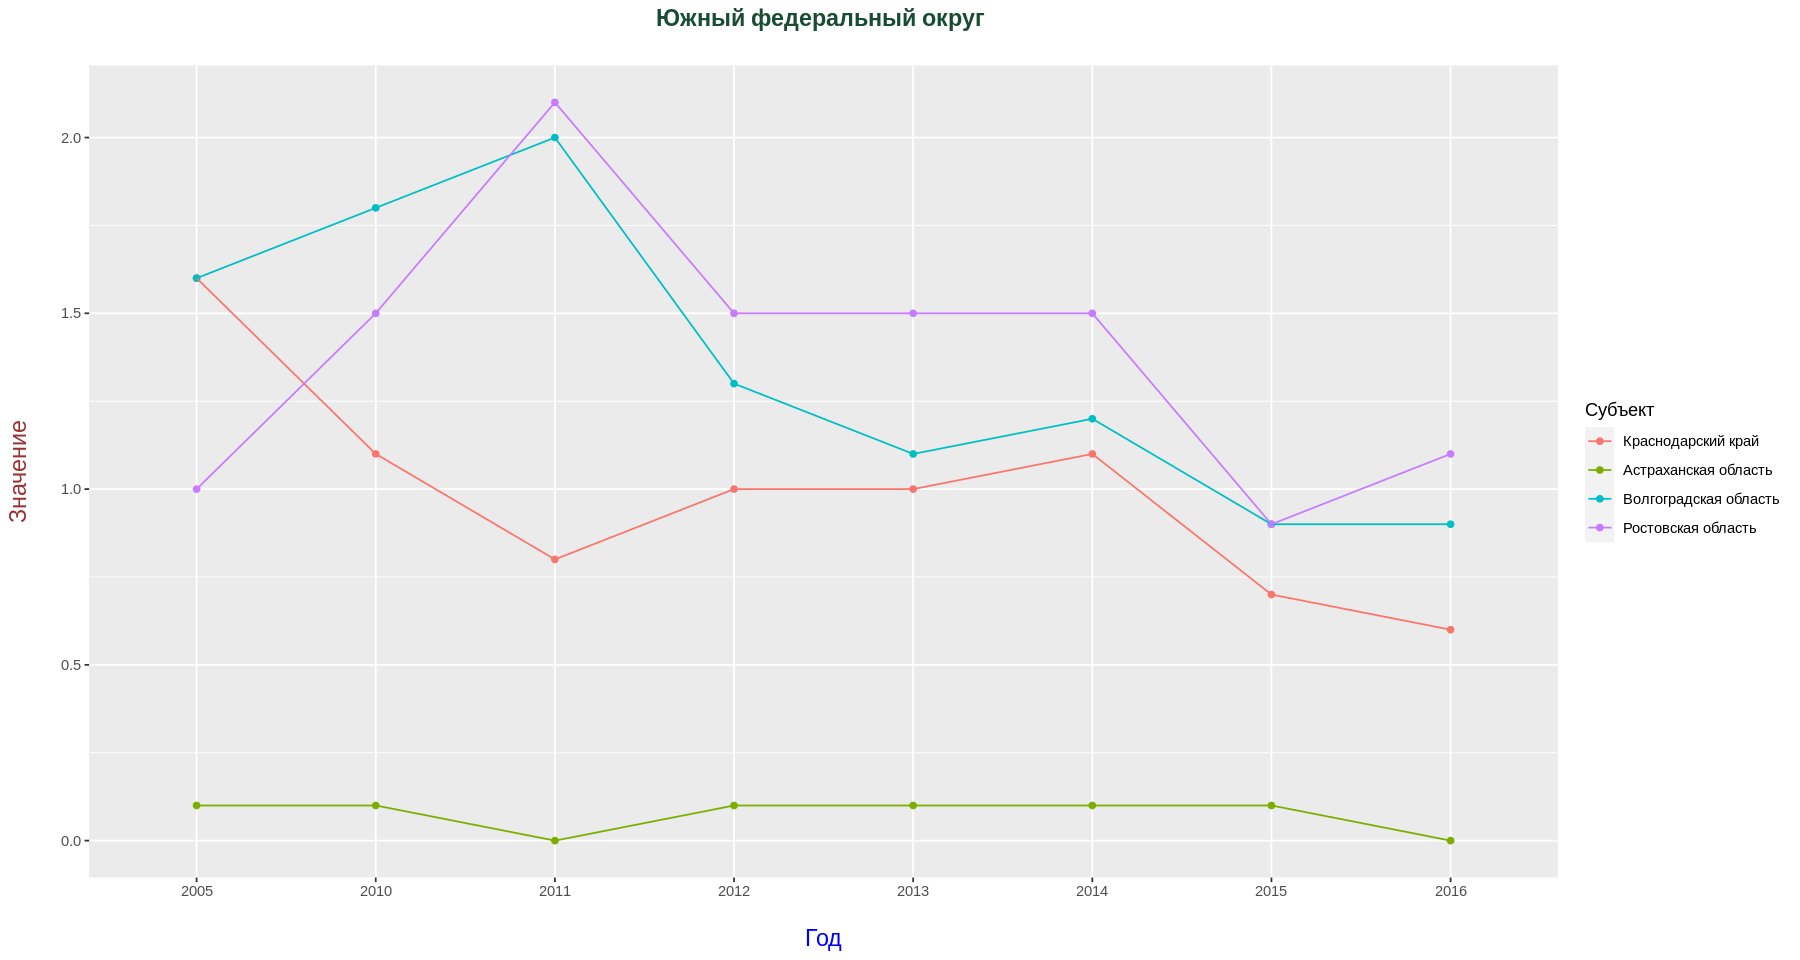

In [79]:
ggplot(melted, aes(x=Year, y=value, colour=variable, group=variable)) +  
  geom_point() + 
  geom_line() + 
  labs(title = paste(distr_name, "\n"), x = "\nГод", y = "Значение\n", color = "Субъект") +
  theme(
    plot.title = element_text(color="#194d33", size=14, face="bold", hjust = 0.5),
    axis.title.x = element_text(color="blue", size=14),
    axis.title.y = element_text(color="#993333", size=14)
  )